# Prediction and Supervised Learning: SDPD

Today, we'll make predictions on the San Diego Police Dept traffic stops dataset, paying attention to which attributes contribute most to our model.

Among the questions we'll ask, are
* Can you predict the age/gender/ethnicity based on other factors? (which are regression? classification?)
* Can you predict who will be search or arrested, based on attributes of the stopped driver?

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from datascience import *

### Clean the SDPD 

As machine learning algorithms usually require numeric input, the cell below cleaned the SDPD data in a standard way.
* Yes/No fields have been changed to 1/0.
* Fields not conforming to a the expected values were given the value -1.
    - you will likely want to filter out rows with -1 values before doing predictions!
* The ethnicities are encoded with integers using `race_dict`

In [27]:
import pandas as pd
sdraw = pd.read_csv('../01.Traffic_Stops/1.messy_data/data/vehicle_stops_2016_datasd.csv')

# convert string date to date-time object
sdraw['timestamp'] = pd.to_datetime(sdraw.timestamp)

cleaned = pd.DataFrame()
cleaned['stop_id'] = sdraw['stop_id']

# clean stop_cause
cleaned['is_moving_violation'] = sdraw.stop_cause.apply(lambda x:float(x == 'Moving Violation'))
cleaned['is_equipment_violation'] = sdraw.stop_cause.apply(lambda x:float(x == 'Equipment Violation'))

# service area: all non digits to -1, else same
cleaned['service_area'] = sdraw.service_area.apply(lambda x:x if x.isdigit() else -1)

# race: translate race codes to integers, given in race_dict
race_dict = dict(zip(sdraw.subject_race.unique(), range(1000)))
cleaned['subject_race'] = sdraw.subject_race.apply(lambda x: race_dict.get(x))

# sex: M=>1, F=>0, Else -1
def sex(s):
    if pd.isnull(s):
        return -1
    if s.lower() == 'm':
        return 1
    elif s.lower() == 'f':
        return 0
    else:
        return -1

cleaned['subject_sex'] = sdraw.subject_sex.apply(sex)

# Age: if not number, or > 100, then -1. Else make a float
def age(s):
    if pd.isnull(s):
        return -1
    if not s.isdigit():
        return -1
    if float(s) > 100:
        return -1
    else:
        return float(s)
    
cleaned['subject_age'] = sdraw.subject_age.apply(age)

# Datetime columns, using datetime methods
cleaned['hour'] = sdraw.timestamp.apply(lambda x:x.hour)
cleaned['day_of_week'] = sdraw.timestamp.apply(lambda x:x.dayofweek)
cleaned['day_of_month'] = sdraw.timestamp.apply(lambda x:x.day)
cleaned['month'] = sdraw.timestamp.apply(lambda x:x.month)

# SD resident / searched / arrested

def yes_no(s):
    if pd.isnull(s):
        return -1
    if s.lower() == 'y':
        return 1
    elif s.lower() == 'n':
        return 0
    else:
        return -1
    
cleaned['sd_resident'] = sdraw.sd_resident.apply(yes_no)
cleaned['arrested'] = sdraw.arrested.apply(yes_no)
cleaned['searched'] = sdraw.searched.apply(yes_no)

cleaned = cleaned.dropna() # drops any row without a timestamp

In [28]:
sdpd = Table.from_df(cleaned)

In [29]:
sdpd

stop_id,is_moving_violation,is_equipment_violation,service_area,subject_race,subject_sex,subject_age,hour,day_of_week,day_of_month,month,sd_resident,arrested,searched
1308198,0,1,530,0,1,28,0,4,1,1,1,0,0
1308172,1,0,520,1,1,25,0,4,1,1,0,0,0
1308171,1,0,110,2,0,31,0,4,1,1,-1,-1,-1
1308170,1,0,-1,0,0,29,0,4,1,1,0,0,0
1308197,1,0,230,0,1,52,0,4,1,1,0,0,0
1308200,1,0,710,2,1,24,0,4,1,1,1,0,0
1308174,1,0,-1,3,1,20,0,4,1,1,1,0,0
1308199,1,0,440,2,1,50,0,4,1,1,1,0,0
1308979,1,0,310,2,0,25,1,4,1,1,1,0,1
1308965,1,0,240,0,0,23,1,4,1,1,1,0,0


### Is a given traffic stop for a moving violation?

We will try to predict, given a traffic stop, was it a moving violation?

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# X=attributes for training; y=labels

# is_moving/equipment_violation are the labels, so we need to take them out!
train_table = sdpd.drop('stop_id', 'is_moving_violation', 'is_equipment_violation')
X = train_table.values
y = sdpd.column('is_moving_violation')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier()

In [10]:
rfc.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Check the models accuracy:
* Is this accuracy even any good?
* What are the models "False positives"
    - the model guessed moving violation, when it wasn't
* What are the models "False negatives"
    - the model guess it wasn't a moving violation, when it was
* What are the properties of examples the model thought were moving violations?   

In [44]:
predict_sdpd

stop_id,is_moving_violation,is_equipment_violation,service_area,subject_race,subject_sex,subject_age,hour,day_of_week,day_of_month,month,sd_resident,arrested,searched,prediction,scores
1308198,0,1,530,0,1,28,0,4,1,1,1,0,0,0,0.4
1308172,1,0,520,1,1,25,0,4,1,1,0,0,0,1,1
1308171,1,0,110,2,0,31,0,4,1,1,-1,-1,-1,1,1
1308170,1,0,-1,0,0,29,0,4,1,1,0,0,0,1,0.8
1308197,1,0,230,0,1,52,0,4,1,1,0,0,0,1,1
1308200,1,0,710,2,1,24,0,4,1,1,1,0,0,1,0.8
1308174,1,0,-1,3,1,20,0,4,1,1,1,0,0,1,0.9
1308199,1,0,440,2,1,50,0,4,1,1,1,0,0,1,0.8
1308979,1,0,310,2,0,25,1,4,1,1,1,0,1,1,0.9
1308965,1,0,240,0,0,23,1,4,1,1,1,0,0,1,0.9


In [11]:
# Accuracy of the model
rfc.score(X_test, y_test)

0.7277841595240199

In [36]:
# Code
predict_sdpd = sdpd.with_columns(
    'prediction', rfc.predict(X),
    'scores', rfc.predict_proba(X)[:,1]
)
np.unique(predict_sdpd.column('subject_race'))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

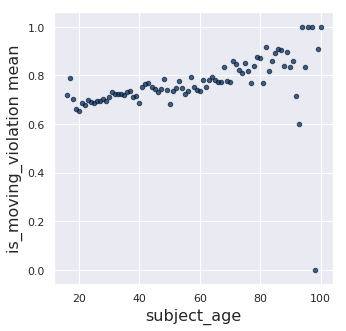

In [65]:
# Code
age_mv = sdpd.where(
    'subject_age', 
    are.above(15)
    ).select('subject_age', 'is_moving_violation').group('subject_age', np.mean)
age_mv.scatter('subject_age')

In [66]:
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz))/np.std(xyz)  
def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

In [67]:
slope(age_mv, 'subject_age', 'is_moving_violation mean')

0.0019213950359815834

In [ ]:
predict_sdpd.where('subject_race', are.between(0, 5)).select('subject_race', 'scores')

### Feature importances
In decision tree based models, you can look at the importance of each feature to the model

* Which features are most important?
* Which values of those features are associated with moving violations?

In [12]:
importances = rfc.feature_importances_
for x,y in sorted(zip(train_table.labels, importances)):
    print(x,'\t\t\t', y)

arrested 			 0.0
day_of_month 			 0.169223781338929
day_of_week 			 0.07563946829936631
hour 			 0.1618590876591788
month 			 0.11384710029087572
sd_resident 			 0.0
searched 			 0.0
service_area 			 0.16939986885434827
subject_age 			 0.2481120567405671
subject_race 			 0.0619186368167348
subject_sex 			 0.0


In [ ]:
# Code

In [ ]:
# Code

### Try other ML model types
* `GradientBoostingClassifier` is a sequential decision tree model
    - each subsequent tree improves upon the misclassifications of the previous tree.
    - it has a `feature_importances_` attribute as well
* `LogisticRegression` is a regression based classifier
    - the importance of the features can be access through the attribute `coef_`.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## Next steps: 

Try other prediction problems, such as those listed at the top of the notebook. As always try to understand *why* the models are making the decisions that they are!